In [1]:
import numpy as np
import pandas as pd
import queue
import threading
from os import listdir
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm,LogNorm
import matplotlib.cm as cm
from importlib import reload
import tqdm.notebook as tqdm

In [63]:
import fast_binning
reload(fast_binning)

<module 'fast_binning' from '/root/docs/gas_flow_project/fast_binning.py'>

12Hz blower frequency data
- Data processing pipeline:
    Setup appropriate bins (semi-automated) -> expand with additional variables -> compute binning

In [3]:
dir_ = "onderive_data_2/12Hz/"

In [4]:
test_path = dir_ + "layer368.csv"
test = pd.read_csv(test_path,header=0,index_col=0)
var_labels = test.loc[:,"Photodiode":].columns.drop(["Z","Frame","Layer"])
x_grid,y_grid = fast_binning.optimal_grid(["X","Y"],
                                          test,
                                          [4,4],
                                          sub_divisions=6,
                                          aux_variable="P",
                                          tol=1000.0)
# Get a dictionary that can be used to convert dtype for csv reads. 
col_types = {col:np.float32 if test[col].dtype == "float64" else np.uint32 if test[col].dtype == "int64" else None for col in test.columns}

In [5]:
XY_data = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

In [101]:
for file in tqdm.tqdm(listdir(dir_)):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c',dtype=col_types)
    df = fast_binning.expand_df(df)
    fast_binning.process_dataframe(df,XY_data,th_data,Zl_data)

  0%|          | 0/180 [00:00<?, ?it/s]

30Hz blower frequency data
- repeat the data processing pipeline used above. 

In [102]:
dir_ = "onderive_data_2/30Hz/"

XY_data_30Hz = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data_30Hz = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data_30Hz = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

We can visualise these bins for different dependent variables (in this case, different metrics), and different quantities for each bin (e.g. mean values per bin, std per bin, etc.).

In [103]:
for file in tqdm.tqdm(sorted(listdir(dir_),
                             key=lambda f: int(f.split(".")[0][5:]))[:181]
                      ):
    df = pd.read_csv(dir_ + file,header=0,index_col=0)
    df = fast_binning.expand_df(df)
    fast_binning.process_dataframe(df,XY_data_30Hz,th_data_30Hz,Zl_data_30Hz)

  0%|          | 0/181 [00:00<?, ?it/s]

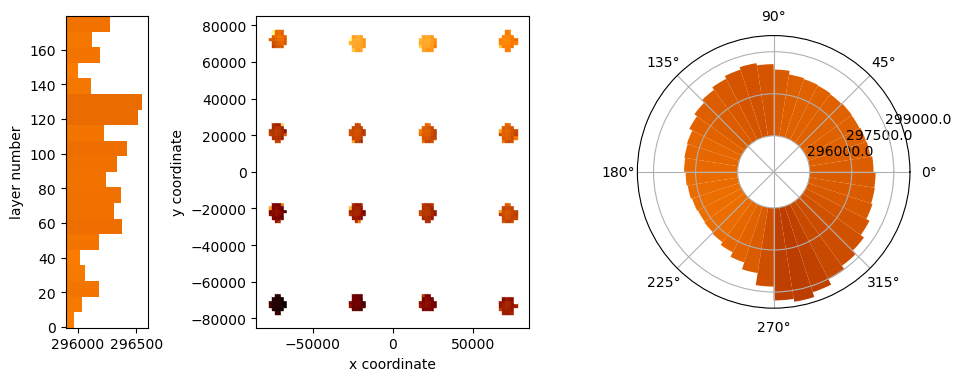

In [113]:
fig = plt.figure(figsize=(9.7,4.0))
ax_z,ax_xy,ax_th,vrange = fast_binning.plot_bins(fig,
                       "Photodiode",
                       XY_data,
                       th_data,
                       Zl_data,
                       "mean")
fig.tight_layout()

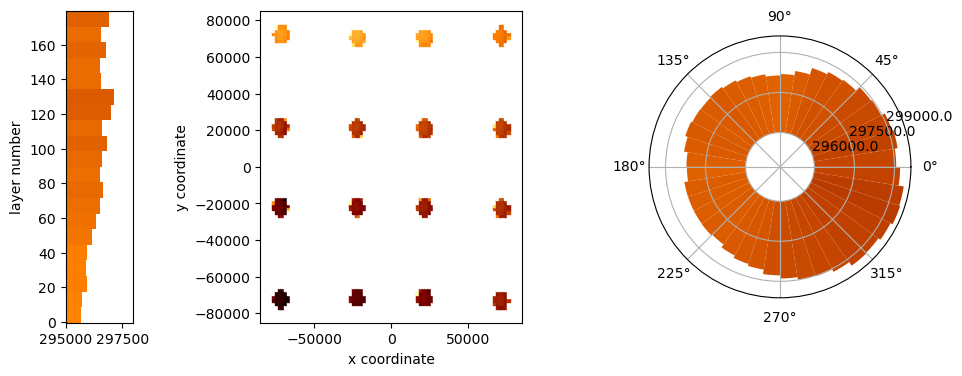

In [105]:
fig = plt.figure(figsize=(9.7,4.0))
fast_binning.plot_bins(fig,
                       "Photodiode",
                       XY_data_30Hz,
                       th_data_30Hz,
                       Zl_data_30Hz,
                       "mean",
                       vrange=vrange)
fig.tight_layout()

In [64]:
from cProfile import Profile
from pstats import SortKey,Stats

In [65]:
XY_data_test = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data_test = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data_test = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

In [66]:
test_2 = pd.read_csv(test_path,header=0,index_col=0,engine='c',dtype=col_types)

In [67]:
test_2.memory_usage(deep=True).sum() / test.memory_usage(deep=True).sum()

0.5166666666666667

In [139]:
with Profile() as profile:
    test_2 = fast_binning.expand_df(test_2)
    fast_binning.process_dataframe(test_2,XY_data_test,th_data_test,Zl_data_test)
    (
        Stats(profile)
        .strip_dirs()
        .sort_stats(SortKey.TIME)
        .print_stats()
    )

         375865 function calls (368417 primitive calls) in 2.869 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  384/288    2.179    0.006    2.194    0.008 {method 'at' of 'numpy.ufunc' objects}
      475    0.081    0.000    0.081    0.000 {pandas._libs.algos.take_2d_axis0_float32_float32}
      372    0.069    0.000    0.069    0.000 {built-in method scipy.fft._pocketfft.pypocketfft.c2c}
       96    0.025    0.000    2.522    0.026 fast_binning.py:198(bin)
      288    0.025    0.000    0.041    0.000 managers.py:1669(_interleave)
      475    0.018    0.000    0.153    0.000 managers.py:691(_slice_take_blocks_ax0)
70059/69771    0.015    0.000    0.024    0.000 {built-in method builtins.isinstance}
     2646    0.013    0.000    0.013    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      186    0.011    0.000    0.016    0.000 fast_binning.py:7(adjust_and_pad)
      950    0.011    0.000    0.011    0.000 {method

In [69]:
dataframe = test_2
self = XY_data_test

In [70]:
Ncount = tuple(np.searchsorted(self.bin_edges[i],dataframe.loc[:,coord_name].values,side='right') for i,coord_name in enumerate(self.coord_names))
for i,coord_name in enumerate(self.coord_names):
    # Check for points on the rightmost bin edge
    on_edge = dataframe.loc[:,coord_name].values == self.bin_edges[i][-1]
    # Move these points one bin to the left
    Ncount[i][on_edge] -= 1
# Use ravel_multi_index to calculate actual bin numbers
xy = np.ravel_multi_index(Ncount,self.nbin)
#hist = np.bincount(xy,minlength=np.prod(self.nbin))
# It's possible that using bincount is faster - need to check. 
values = dataframe.loc[:,self.variable_names].fillna(0.0).to_numpy(dtype=np.float32)
finite_vals = np.isfinite(dataframe.loc[:,self.variable_names]).to_numpy(dtype=np.bool_)

In [71]:
%%timeit
fast_binning.add_at(self.sum_bins,xy,values)

4.59 ms ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
%%timeit
np.add.at(self.sum_bins,xy[None,:],values)

248 ms ± 485 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Test for boolean values.

In [74]:
%%timeit
fast_binning.addBool_at(self.count_bins,xy,finite_vals)

4.78 ms ± 75.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
%%timeit
np.add.at(self.count_bins,xy[None,:],finite_vals)

255 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
